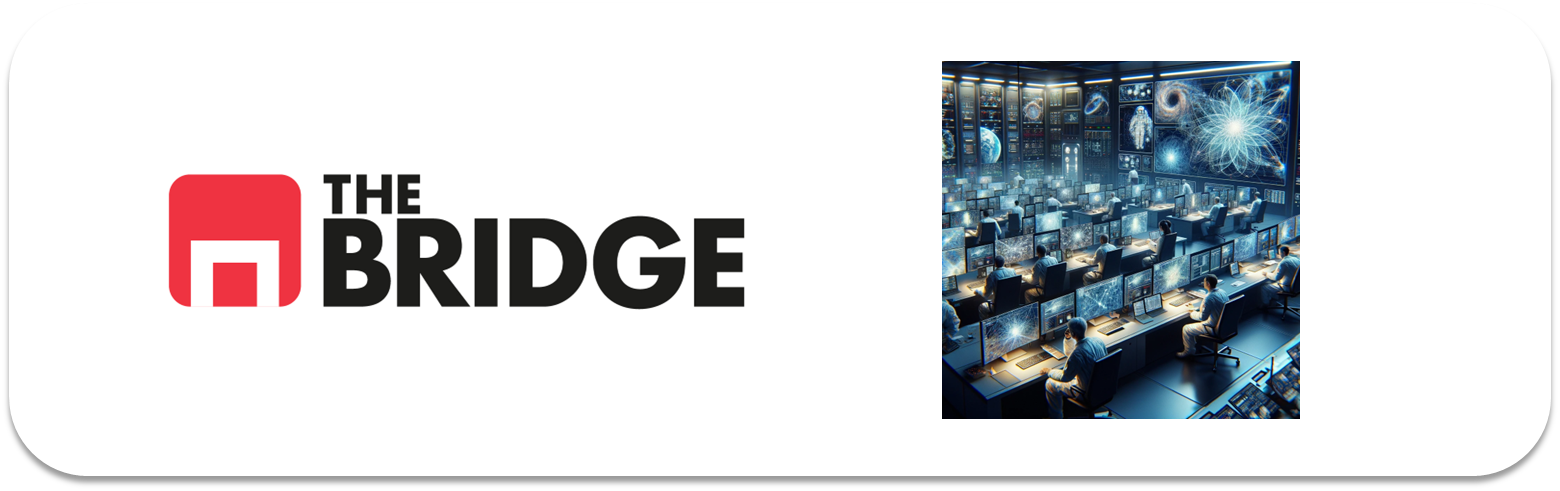

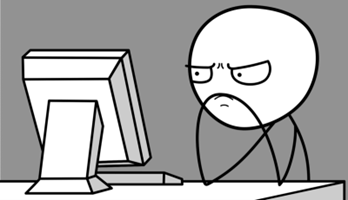

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [96]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de imágenes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 imágenes por cada tipo. Tendrás que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificación de una menor cantidad de casos (sólo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teninendo en cuenta su distribución, para ello tendrás que explorar las estructura. Crea un juego Train,test para resolución 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [2]:
path_base = './data/apples'
path_train = path_base + '/Train'
path_test = path_base + '/Test'

apples = os.listdir(path_train)

def read_data(directorio, reshape_dim=(32,32)):
    X, y = [], []
    for apple in apples:
        path_folder = directorio + '/' + apple
        for file in os.listdir(path_folder):
            image = imread('/'.join([path_folder, file]))
            image = cv2.resize(image, reshape_dim)

            X.append(image)
            y.append(apple)  

    return np.array(X),np.array(y)

In [3]:
X_train, y_train = read_data(path_train)
X_test, y_test = read_data(path_test)
X_reshape, y_reshape = read_data(path_test, reshape_dim=(224,224))

**NOTA:** A partir de aquí emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualización de algunos de los datos. Crea una función que te ayude con ello.

In [6]:
def visualiza(num_images:int, n_col=5, set_image=X_train, set_labels=y_train):
    '''
    num_images: número de imágenes a mostrar \n
    n_col:      número de columnas a mostrar
    '''
    num_list = list(np.random.randint(0, set_image.shape[0], num_images))
    images = set_image[num_list]
    labels = set_labels[num_list]

    columns = n_col if len(images) > n_col else len(images)
    rows = len(images) // 5 if len(images)%5 == 0 else (len(images) // 5) +1
    fig, ax = plt.subplots(rows, columns, figsize=(columns*3, rows*2))
    ax = ax.flatten()
    for index, image in enumerate(images):
        ax[index].imshow(image, cmap='Greys')
        ax[index].axis('off')
        ax[index].set_title(labels[index])

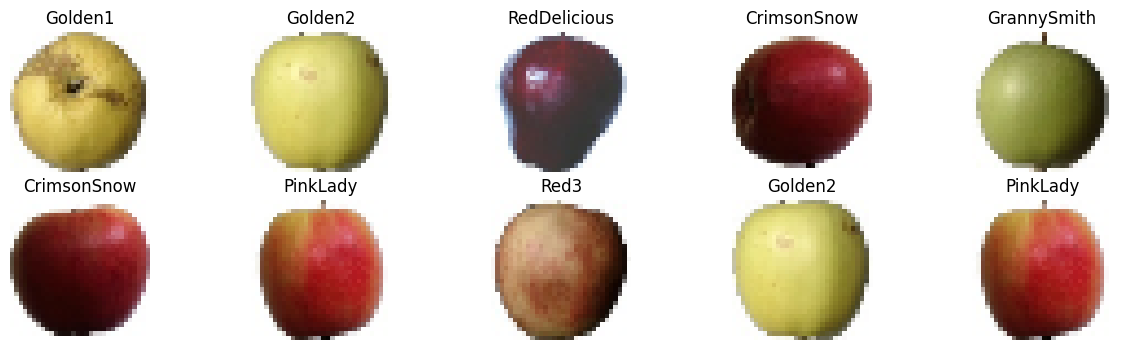

In [18]:
visualiza(10)

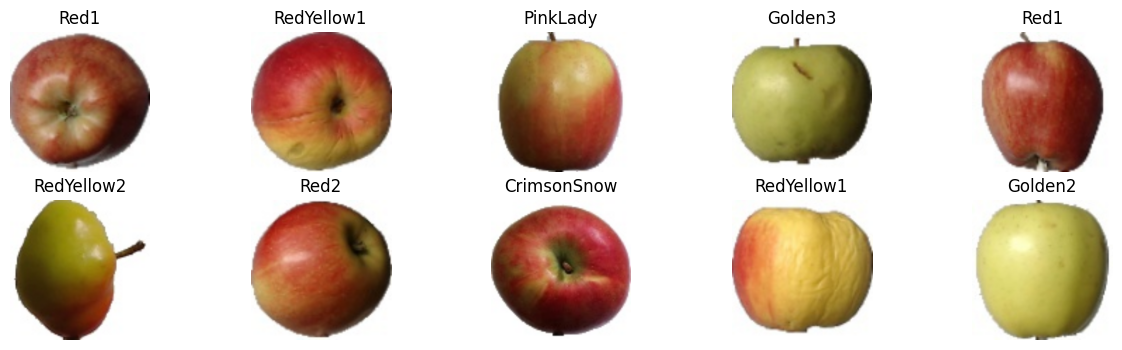

In [20]:
visualiza(10, set_image=X_reshape, set_labels=y_reshape)

### Ejercicio 3

Completa el miniEDA habitual con imágenes y escoge una métrica para el modelo.

In [22]:
pd.Series(y_train).value_counts(True)*100

RedYellow2      10.493442
Golden2          7.682698
Red2             7.682698
GrannySmith      7.682698
Braeburn         7.682698
RedYellow1       7.682698
Red1             7.682698
RedDelicious     7.651468
Golden3          7.510931
Golden1          7.495315
PinkLady         7.120550
CrimsonSnow      6.933167
Red3             6.698938
Name: proportion, dtype: float64

### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la función shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [25]:
X_train     = X_train/255
X_test      = X_test/255
X_reshape   = X_reshape/255

In [26]:
X_shuffle, y_shuffle = shuffle(X_train, y_train, random_state=42)

### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a numéricas, creando dos diccionarios uno que permita traducir de etiqueta a clase numérica y otro que permita la transformación inversa.

In [36]:
dic_apple, dic_cod = {}, {}
for index, apple in enumerate(set(y_test)):
    dic_apple[index] = apple
    dic_cod[apple] = index

### Ejercicio 6: Zero Shot Learning

Descar el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pruébalo contra el test (aquí no valen nuestras categorías serán las que proporcione ResNet ojo). Prueba una selección aleatoria de imágenes del test y compara las etiquetas de ResNet con la que tiene. ¿Nos sirve este clasificador así tal cual?

In [ ]:
model = ResNet50V2(include_top=True, weights='imagenet', input_shape=(224, 224, 3))

102869336/102869336 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


In [71]:
seleccion = np.random.randint(0,len(X_reshape),20)
predictions = model.predict(X_reshape[seleccion])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [79]:
# Hay que descargar el decodificador de predicciones para poder hacer el Zero Shot
from tensorflow.keras.applications.resnet_v2 import decode_predictions

clase = [decodificado[0][1] for decodificado in decode_predictions(predictions)]
pd.DataFrame({'Test':y_reshape[seleccion], 'Predict':clase})

,Test,Predict
0,CrimsonSnow,Granny_Smith
1,GrannySmith,Granny_Smith
2,Red1,Granny_Smith
3,PinkLady,Granny_Smith
4,Red1,Granny_Smith
5,Braeburn,Granny_Smith
6,Red1,Granny_Smith
7,Golden3,Granny_Smith
8,CrimsonSnow,Granny_Smith
9,Golden1,dough


## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activación "relu") y otra de salida con las unidades que crees necesarias y activación la que consideres. Congela las capas del modelo base (la ResNet50). Define también los hiperparámetros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [80]:
model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

for layer in model.layers:
    layer.trainable = False

In [85]:
flatten = layers.Flatten()(model.output)
dense1 = layers.Dense(300, activation='relu')(flatten)
dense2 = layers.Dropout(rate=0.5)(dense1)
out_layer = layers.Dense(13, activation='softmax')(dense2)

cnn_model = Model(model.input, out_layer)
cnn_model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 618,613 (2.36 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evolución del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el número de épocas.

In [91]:
y_shuffle_num = pd.Series(y_shuffle).map(dic_cod)

In [94]:
early = EarlyStopping(patience= 5, restore_best_weights= True)
batch_size = 64

from time import time
t_zero = time()
history = cnn_model.fit(X_shuffle, 
                    y_shuffle_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=1)
print(time() - t_zero)

81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - acc: 0.9380 - loss: 0.2009 - val_acc: 0.9953 - val_loss: 0.0465
16.59594202041626


In [95]:
history = cnn_model.fit(X_shuffle, 
                    y_shuffle_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=20,
                    callbacks=[early])

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 303ms/step - acc: 0.9742 - loss: 0.0943 - val_acc: 0.9953 - val_loss: 0.0358
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 266ms/step - acc: 0.9841 - loss: 0.0687 - val_acc: 0.9992 - val_loss: 0.0269
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 230ms/step - acc: 0.9870 - loss: 0.0599 - val_acc: 0.9992 - val_loss: 0.0176
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step - acc: 0.9892 - loss: 0.0467 - val_acc: 0.9992 - val_loss: 0.0116
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - acc: 0.9906 - loss: 0.0372 - val_acc: 0.9992 - val_loss: 0.0113
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - acc: 0.9945 - loss: 0.0302 - val_acc: 1.0000 - val_loss: 0.0109
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - acc: 0.9760 - loss: 0.0827 - val_acc: 0.9992 - val_loss: 0.0105
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - acc: 0.9933 - loss: 0.0297 - val_acc: 0.9984 - val_loss: 0.0080
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 230ms/

### Ejercicio 9

Evalua el modelo contra test y haz un pequeño análisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un pequeño análisis de errores.

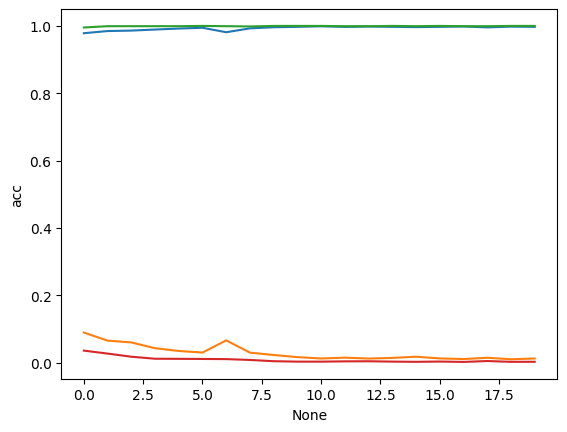

In [100]:
hist_df = pd.DataFrame(history.history)
for feature in hist_df.columns:
    sns.lineplot(hist_df, x=hist_df.index, y=feature)

In [102]:
y_test_num = pd.Series(y_test).map(dic_cod)
cnn_model.evaluate(X_test, y_test_num)

67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - acc: 0.8651 - loss: 0.5154


[0.6554777026176453, 0.8430178165435791]

In [103]:
y_pred = [np.argmax(prediccion) for prediccion in cnn_model.predict(X_test)]

print(classification_report(y_test_num, y_pred))

67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step
              precision    recall  f1-score   support

           0       1.00      0.54      0.70       144
           1       0.84      0.90      0.87       148
           2       0.98      0.80      0.88       164
           3       0.66      0.66      0.66       164
           4       0.83      1.00      0.91       164
           5       0.68      0.95      0.79       164
           6       1.00      1.00      1.00       219
           7       1.00      1.00      1.00       166
           8       0.75      0.84      0.79       152
           9       1.00      0.75      0.86       164
          10       0.65      0.70      0.67       161
          11       0.99      0.79      0.88       164
          12       0.80      0.95      0.87       160

    accuracy                           0.84      2134
   macro avg       0.86      0.84      0.84      2134
weighted avg       0.86      0.84      0.84      2134



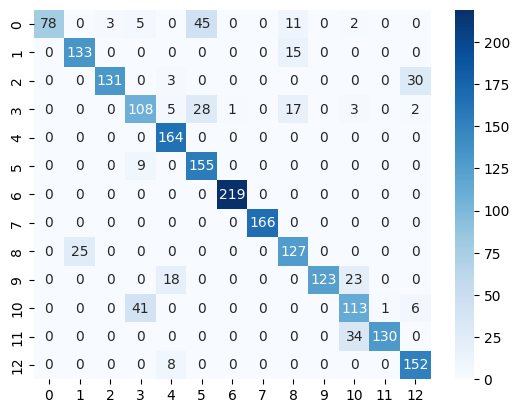

In [106]:
sns.heatmap(confusion_matrix(y_test_num, y_pred), annot=True, fmt='.4g', cmap='Blues');

In [108]:
dic_apple

{0: np.str_('Red3'),
 1: np.str_('CrimsonSnow'),
 2: np.str_('Red1'),
 3: np.str_('Red2'),
 4: np.str_('RedYellow1'),
 5: np.str_('Braeburn'),
 6: np.str_('RedYellow2'),
 7: np.str_('RedDelicious'),
 8: np.str_('PinkLady'),
 9: np.str_('Golden2'),
 10: np.str_('Golden3'),
 11: np.str_('GrannySmith'),
 12: np.str_('Golden1')}

## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

In [ ]:
base_model = ResNet50V2(include_top=False, weights=None, input_shape=(32, 32, 3))

flatten = layers.Flatten()(base_model.output)
dense1 = layers.Dense(300, activation='relu')(flatten)
dropout = layers.Dropout(rate=0.5)(dense1)
out_layer = layers.Dense(13, activation='softmax')(dropout)

model = Model(base_model.input, out_layer)
model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

model.summary()

### Ejercicio 11
Entrena con batch_size a 64 y 60 épocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente más largo, así que tómate un descanso). Muestra la evolución y da una posible justificación a emplear tantas épocas de partida.

In [113]:
batch_size = 64
epochs = 60
early = EarlyStopping(restore_best_weights= True, patience= 10)

history = model.fit(X_shuffle, y_shuffle_num, 
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=epochs,
                    callbacks=[early])

Epoch 1/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - acc: 0.6660 - loss: 1.0515 - val_acc: 0.0695 - val_loss: 4.7680
Epoch 2/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 531s 7s/step - acc: 0.9221 - loss: 0.2807 - val_acc: 0.0695 - val_loss: 11.5655
Epoch 3/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - acc: 0.9220 - loss: 0.2600 - val_acc: 0.1007 - val_loss: 13.5345
Epoch 4/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 531s 7s/step - acc: 0.9444 - loss: 0.2368 - val_acc: 0.1405 - val_loss: 26.5113
Epoch 5/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - acc: 0.8766 - loss: 0.5211 - val_acc: 0.2139 - val_loss: 10.3066
Epoch 6/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - acc: 0.9369 - loss: 0.2635 - val_acc: 0.4442 - val_loss: 4.1725
Epoch 7/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 1065s 13s/step - acc: 0.9592 - loss: 0.1532 - val_acc: 0.8970 - val_loss: 0.4767
Epoch 8/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - acc: 0.9029 - loss: 0.4478 - val_acc: 0.6214 - val_loss: 3.1621
Epoch 9/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - acc: 

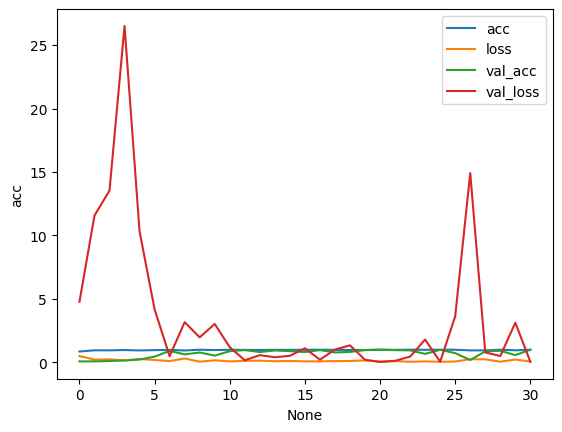

In [118]:
hist_df = pd.DataFrame(history.history)

for feature in hist_df.columns:
    sns.lineplot(hist_df, x=hist_df.index, y=feature, label=feature);

### Ejercicio 12

Muestra la evaluación contra el test, el informe de clasificación  y la matriz de confusión. Compara los resultados con los del ejercicio 9.

In [119]:
model.evaluate(X_test, y_test_num)

67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - acc: 0.8658 - loss: 0.8082


[0.430541068315506, 0.9067478775978088]

67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step
              precision    recall  f1-score   support

    Braeburn       0.95      0.66      0.78       164
 CrimsonSnow       0.96      1.00      0.98       148
     Golden1       0.80      0.89      0.84       160
     Golden2       1.00      0.77      0.87       164
     Golden3       0.92      1.00      0.96       161
 GrannySmith       1.00      0.94      0.97       164
    PinkLady       1.00      0.96      0.98       152
        Red1       1.00      0.55      0.71       164
        Red2       0.57      1.00      0.73       164
        Red3       0.99      1.00      1.00       144
RedDelicious       1.00      1.00      1.00       166
  RedYellow1       0.93      1.00      0.96       164
  RedYellow2       1.00      1.00      1.00       219

    accuracy                           0.91      2134
   macro avg       0.93      0.91      0.91      2134
weighted avg       0.93      0.91      0.91      2134



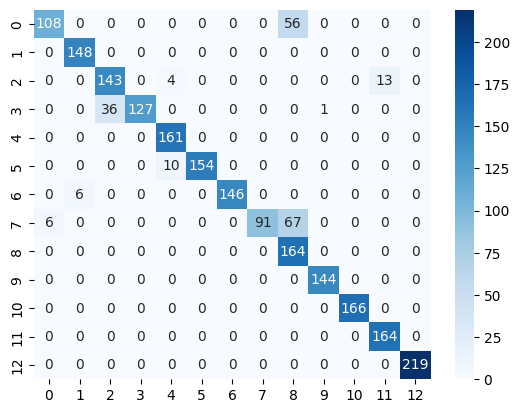

In [125]:
y_pred_num = [np.argmax(prediction) for prediction in model.predict(X_test)]
y_pred = pd.Series(y_pred_num).map(dic_apple)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.4g', cmap='Blues');